In [4]:
# %%
import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import umap                         
  

ID-like columns dropped: ['ID', 'height_above', 'Unnamed: 0']
Final feature matrix shape: (1147, 60)


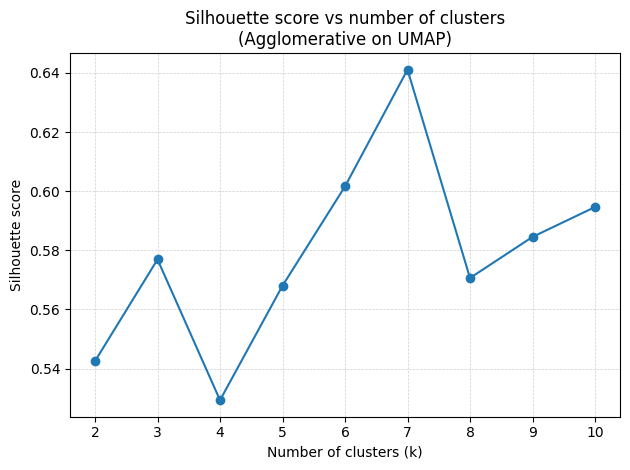

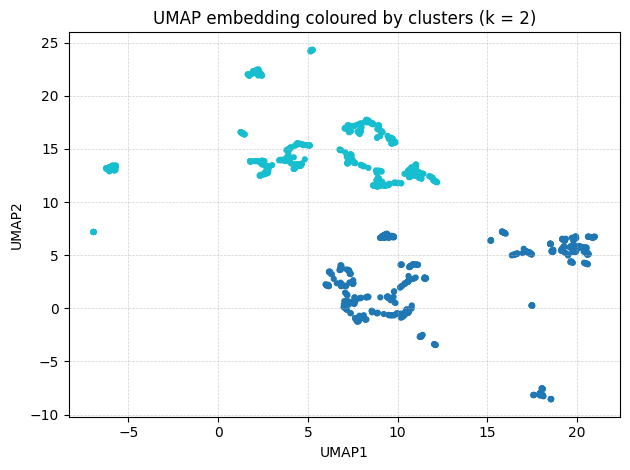

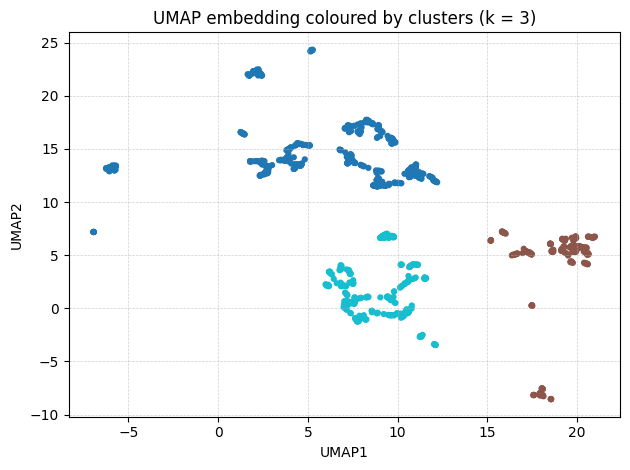

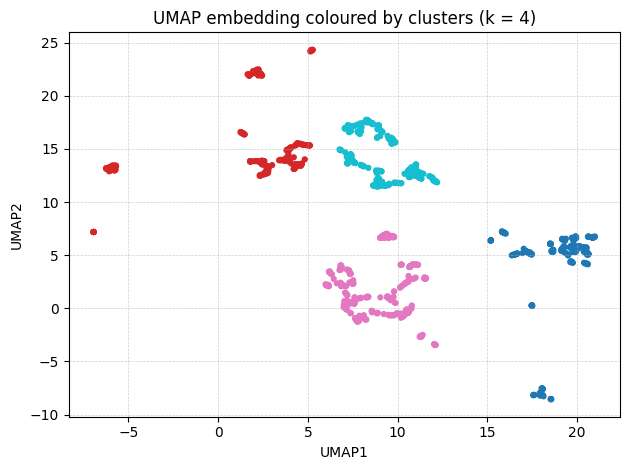

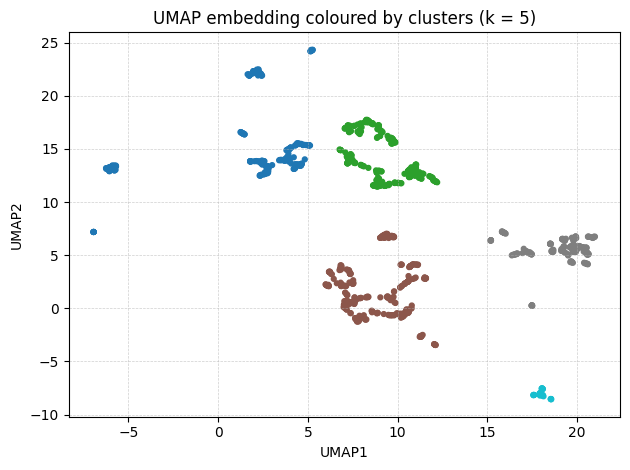

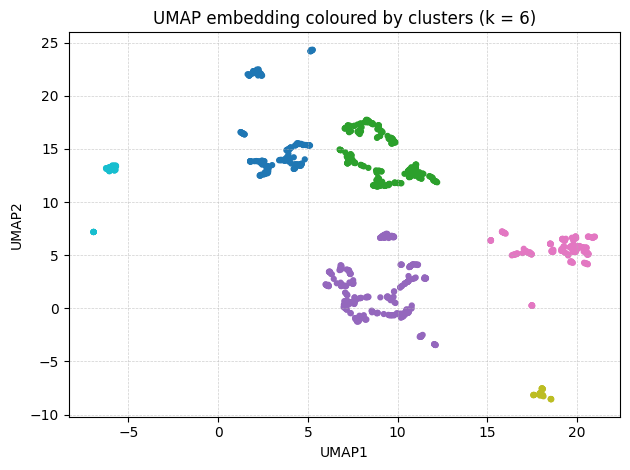

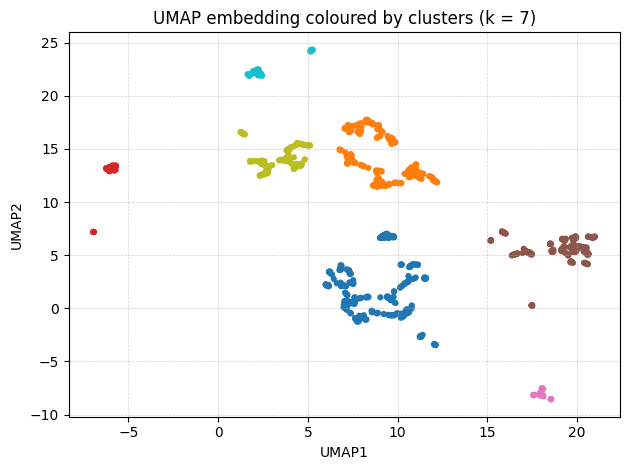

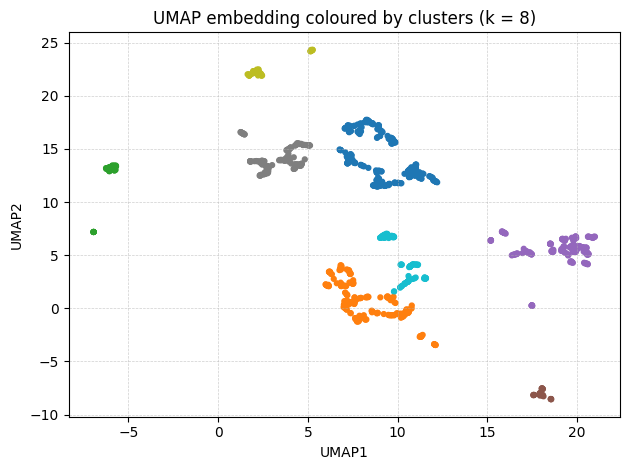

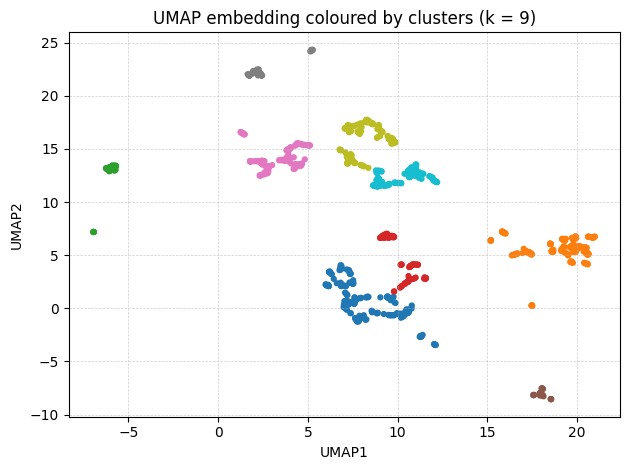

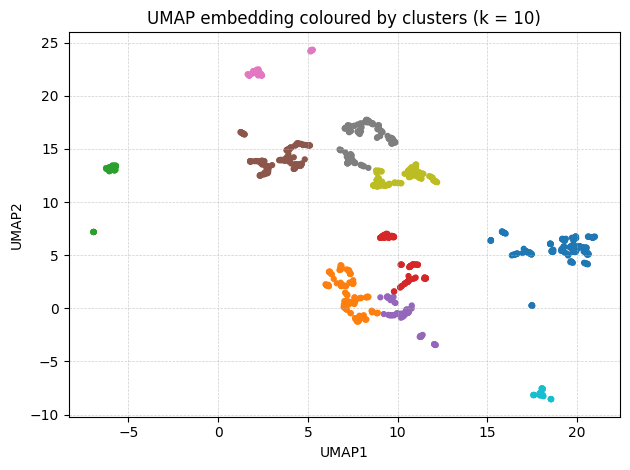

All done! Files saved in → D:\IGUIDE\results


In [10]:

# ## Parameters
INPUT_CSV    = "combined_features.csv"   # path to your data
OUTPUT_DIR   = "Input_Clustering_Results"                 # folder to save figures / CSVs
SEED         = 42                        # random state for reproducibility
K_MIN, K_MAX = 2, 10                     # range of cluster counts
N_NEIGHBORS  = 15                        # UMAP n_neighbors
MIN_DIST     = 0.1                       # UMAP min_dist


# %%
def find_id_like_columns(df: pd.DataFrame) -> list[str]:
    id_like = []
    for c in df.columns:
        cl = c.lower()
        if (
            cl in {"id", "ids", "index", "record_id", "uid", "gid"}
            or cl.startswith(("id_", "idx"))
            or cl.endswith("_id")
            or cl == "unnamed: 0"
            or cl == "height_above"
        ):
            id_like.append(c)
    return id_like

# ##  Load data & preprocess
os.makedirs(OUTPUT_DIR, exist_ok=True)

df_raw = pd.read_csv(INPUT_CSV)
id_cols = find_id_like_columns(df_raw)

print("Not wanted columns dropped:", id_cols or "None")

# Drop IDs, coerce non-numeric to numeric, drop all-NaN cols
X_df = df_raw.drop(columns=id_cols, errors="ignore").copy()
for col in X_df.columns:
    if not np.issubdtype(X_df[col].dtype, np.number):
        X_df[col] = pd.to_numeric(X_df[col], errors="coerce")

nan_cols = [c for c in X_df.columns if X_df[c].isna().all()]
if nan_cols:
    X_df.drop(columns=nan_cols, inplace=True)
    print("All-NaN columns dropped:", nan_cols)

# scale
X = SimpleImputer(strategy="median").fit_transform(X_df.values)
X = StandardScaler().fit_transform(X)

print(f"Final feature matrix shape: {X.shape}")

# ## UMAP embedding (2-D)

# %%
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=N_NEIGHBORS,
    min_dist=MIN_DIST,
    metric="euclidean",
    random_state=SEED,
)
embedding = reducer.fit_transform(X)          # (n_samples, 2)

# DataFrame for easy plotting / saving
emb_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])

# Clustering + silhouette

# %%
k_range = range(K_MIN, K_MAX + 1)
labels_by_k = {}
silhouette_rows = []

for k in k_range:
    model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = model.fit_predict(embedding)
    labels_by_k[k] = labels
    sil = silhouette_score(embedding, labels, metric="euclidean")
    silhouette_rows.append({"k": k, "silhouette": sil})

sil_df = pd.DataFrame(silhouette_rows)
sil_df.to_csv(f"{OUTPUT_DIR}/silhouette_scores.csv", index=False)

# %% [markdown]
# ##  Plot silhouette curve

# %%
plt.figure()
plt.plot(sil_df["k"], sil_df["silhouette"], marker="o")
plt.title("Silhouette score vs number of clusters\n(Agglomerative on UMAP)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(True, ls="--", lw=0.5, alpha=0.6)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/silhouette_scores.png", dpi=150)
plt.show()

# ## UMAP scatter for each *k*

# %%
for k in k_range:
    plt.figure()
    plt.scatter(
        emb_df["UMAP1"], emb_df["UMAP2"],
        c=labels_by_k[k], s=12, cmap="tab10"
    )
    plt.title(f"UMAP embedding coloured by clusters (k = {k})")
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
    plt.grid(True, ls="--", lw=0.5, alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/umap_k{k}.png", dpi=150)
    plt.show()

# ##  Save embedding + all labels (optional)

# %%
out_df = emb_df.copy()
# keep original IDs only for reference
for c in id_cols:
    out_df[c] = df_raw[c].values
# attach label columns
for k in k_range:
    out_df[f"labels_k{k}"] = labels_by_k[k]

out_df.to_csv(f"{OUTPUT_DIR}/umap_embedding_and_labels.csv", index=False)
print("All done! Files saved in →", os.path.abspath(OUTPUT_DIR))
